In [1]:
############################################
# imports
############################################

import pyBigWig
import scipy.io as sio
import numpy as np
import math 
import matplotlib.pyplot as plt
import os
import pandas as pd
from heapq import nlargest
import copy
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle
import seaborn as sns
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold
#chromosomes = [f'chr{chrom}' for chrom in chromosomes]

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)

########################################################################
# create the cell type dictionary
# [TO DO] This needs to be replaced with SNPS code 
########################################################################
# Define the path file with prefixes and colors in the following form
#1       sc1.ACTTGA      red
#2       sc1.GCCAAT      red
#3       sc1.TAGCTT      red
#4       sc10.TAGCTT     blue
#
filename = '../../bin/name.order.HCG_methy.with_color.txt'

# Initialize an empty dictionary to store cell ID and color
cell_color_dict = {}

# Open and read the file
with open(filename, 'r') as file:
    for line in file:
        # Split the line into parts
        parts = line.strip().split()
        # Extract cell ID and color
        cell_id = parts[1]
        color = parts[2]
        # Store in dictionary
        cell_color_dict[cell_id] = color

# Define the path to the tensor sample order file
#This file contains the prefixes in the form
#sc11.ACTTGA
#sc11.CGATGT
#sc11.GCCAAT
#
tensor_order_filename = f'{output_directory}/filtered_bam_list.txt'

# Initialize a list to store the 1s and 0s
color_vector = []

# Open and read the tensor sample order file
with open(tensor_order_filename, 'r') as file:
    for line in file:
        sample_id = line.strip()  # Remove any trailing newlines or spaces
        if sample_id in cell_color_dict and cell_color_dict[sample_id] == 'red':
            color_vector.append(1)
        else:
            color_vector.append(0)

# Output the color vector to check
print(len(color_vector))

# Create a mapping dictionary
color_mapping = {
    'red': 'imr90',
    'blue': 'gm12878'
}

# Update the dictionary using the mapping
updated_cell_color_dict = {key: color_mapping[value] for key, value in cell_color_dict.items()}

#################################################################################
#create dark bins file if not already created
#################################################################################

# Check if the bins to remove file has already been created
bins_file_path = f'{output_directory}/bins_to_remove_res{resolution_label}.npz'
if os.path.exists(bins_file_path):
    print(f"{bins_file_path} already exists. Skipping computation.")
    #load the dark regions data and the A/B compartment data
    loaded_data = np.load(bins_file_path)
    # Convert the loaded data back into a dictionary with the same structure
    bins_to_remove = {chrom: loaded_data[chrom] for chrom in loaded_data}
else:
    bigwig_file = "../../bin/softwarefiles/dark_regions_hg19.bigWig"
    # Open the BigWig file
    bw = pyBigWig.open(bigwig_file)

    # Define the chromosomes you want to analyze
    chromosomes = ['chr' + str(i) for i in range(1, 23)] 

    # Define the threshold for removing bins based on average mappability
    threshold = mappability_threshold

    # Create a dictionary to store the bin indices to remove for each chromosome
    bins_to_remove = {}

    # Loop through each chromosome
    for chrom in chromosomes:
        chrom_size = bw.chroms(chrom)

        if chrom_size is None:
            print(f"Chromosome {chrom} not found in the BigWig file.")
            continue

        # Calculate the number of bins based on the specified resolution
        num_bins = math.ceil(chrom_size / resolution) #last bin may not be of size resolution

        # Create lists to store bin indices to remove
        remove_indices = []

        # Calculate average mappability for each bin
        for i in range(num_bins):
            # Determine the start and end positions of the bin
            start = i * resolution
            end = min((i + 1) * resolution, chrom_size)  # to account for last bin which may be incomplete

            # Extract the mappability values for the bin
            values = np.nan_to_num(bw.values(chrom, start, end))

            # Calculate the average mappability score for the bin
            avg_mappability = np.mean(values)

            # Check if the average mappability is below the threshold
            if avg_mappability < threshold:
                remove_indices.append(i)

        # Store the bin indices to remove for this chromosome
        bins_to_remove[chrom] = remove_indices

    # Close the BigWig file
    bw.close()

    # Convert the lists in bins_to_remove to numpy arrays
    for chrom in bins_to_remove:
        bins_to_remove[chrom] = np.array(bins_to_remove[chrom])

    # Save the dictionary as an .npz file
    np.savez(bins_file_path, **bins_to_remove)
    print(f"Bins to remove file created and saved to {bins_file_path}")

###########################################################################    
#create a dictionary of the A/B compartment calls for the bulk data
###########################################################################
bulk_data = {}
path_to_eigenvectors = '../../projects/single_cell_files/eigenvector/'

for i in range(1, 23):
    file = path_to_eigenvectors + f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector.txt'
    key = os.path.splitext(os.path.basename(file))[0]  
    bulk_data[key] = pd.read_csv(file, header=None, names=['eigenvalue'])
    file = path_to_eigenvectors + f'res{resolution}_ch{i}_oe_IMR90_KR_eigenvector.txt'
    key = os.path.splitext(os.path.basename(file))[0]  
    bulk_data[key] = pd.read_csv(file, header=None, names=['eigenvalue'])
    
###########################################################################
# download H3K9ac file if it does not exist
###########################################################################

def calculate_bin_averages(data, elements_per_bin):
    num_bins = math.ceil(len(data)/elements_per_bin)
    bin_averages = np.zeros(num_bins)
    for i in range(num_bins):
        start_index = i * elements_per_bin
        end_index = min((i + 1) * elements_per_bin, len(data))
        bin_data = data[start_index:end_index]
        if len(bin_data) > 0:
            bin_averages[i] = np.mean(bin_data)
        else:
            bin_averages[i] = 0
    return np.nan_to_num(bin_averages, nan=0.0)

# Read chromosome sizes from hg19.autosome.chrom.sizes
lengths = {}
with open(chrom_file, 'r') as file:
    for line in file:
        chrom, size = line.strip().split()
        lengths[chrom] = int(size)

# Check if the output file already exists
output_file = f'../../bin/softwarefiles/h3k9ac_res{resolution}_GM12878.pkl'

if not os.path.exists(output_file):
    # Initialization
    chromosomes = list(lengths.keys())
    h3k9ac = {name: [] for name in chromosomes}

    bigwig_H3K9ac_path = '../../bin/softwarefiles/ENCFF128UVW_hg19_H3K9ac_GM12878.bigWig'
    if not os.path.exists(bigwig_H3K9ac_path):
        os.system(f'wget https://www.encodeproject.org/files/ENCFF128UVW/@@download/ENCFF128UVW.bigWig -O {bigwig_H3K9ac_path}')

    bigwig_H3K9ac = pyBigWig.open(bigwig_H3K9ac_path)
    
    # Process each chromosome
    for chromosome_name in chromosomes:
        start_position = 1
        end_position = lengths[chromosome_name]
        values_file1 = np.array(bigwig_H3K9ac.values(chromosome_name, start_position, end_position))
        h3k9ac[chromosome_name] = calculate_bin_averages(values_file1, resolution)

    # Save the results in a pickle file
    with open(output_file, 'wb') as file:
        pickle.dump(h3k9ac, file)
else:
    print(f"The file {output_file} already exists.")
    with open(output_file, 'rb') as file:
        h3k9ac = pickle.load(file)

################################################################################    
#make sure each GM12878 eigenvector has positive value for active A compartment
################################################################################
for i in range(1, 23):
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    chromosome_key = f'chr{i}'
    h3k9ac_df = pd.DataFrame(h3k9ac[chromosome_key], columns=['H3K9ac_signal'])
    
    df_gm12878_positive = bulk_data[key_gm12878]['eigenvalue']  
    df_gm12878_negative = -bulk_data[key_gm12878]['eigenvalue']

    # Compute correlations by first ensuring eigenvector data is in DataFrame format
    corr_positive = df_gm12878_positive.corr(h3k9ac_df['H3K9ac_signal'])
    corr_negative = df_gm12878_negative.corr(h3k9ac_df['H3K9ac_signal'])
    if corr_negative > corr_positive:
        bulk_data[key_gm12878]['eigenvalue'] = -bulk_data[key_gm12878]['eigenvalue']
        print(f"Switched for chromosome {i}")    

###############################################################################    
#make sure each IMR90 eigenvector has consistent orientation with GM12878
################################################################################
for i in range(1, 23):
    # Construct keys for GM12878 and IMR90
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    
    # Retrieve DataFrames for GM12878 and IMR90
    df_gm12878 = bulk_data[key_gm12878]
    df_imr90 = bulk_data[key_imr90]
    
    # Ensure data is in expected format
    if not df_gm12878.empty and not df_imr90.empty:
        # Concatenate DataFrames side-by-side
        combined_df = pd.concat([df_gm12878.reset_index(drop=True), df_imr90.reset_index(drop=True)], axis=1, keys=['gm12878', 'imr90'])
        
        # Drop rows with NaN values in either column
        combined_df.dropna(inplace=True)
        
        # Extract Series after dropping NaNs
        gm12878_series = combined_df['gm12878']['eigenvalue']
        imr90_series = combined_df['imr90']['eigenvalue']

        # Calculate correlations
        corr_positive = gm12878_series.corr(imr90_series)
        corr_negative = gm12878_series.corr(-imr90_series)

        # If negating IMR90 improves correlation, update the original data
        if corr_negative > corr_positive:
            bulk_data[key_imr90]['eigenvalue'] = -bulk_data[key_imr90]['eigenvalue']
            print(f"switched for chromosome {i}")

#The A/B compartments of the proper orientation before dropping dark regions
original_bulk_data = copy.deepcopy(bulk_data)

#################################################################################
#remove dark regions
#dark reigons are obviously correlated
#I want to remove dark regions to get meeaningfully correlated regions
###############################################################################

for i in range(1, 23):
    # Construct the keys for GM12878 and IMR90
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_IMR90_KR_eigenvector'
    chrom = f'chr{i}'

    # Check if the chromosome exists in the bins_to_remove and in the data
    if chrom in bins_to_remove and key_gm12878 in bulk_data and key_imr90 in bulk_data:
        # Retrieve the indices to remove for this chromosome
        indices_to_remove = bins_to_remove[chrom]

        # Initialize lists to hold valid indices for both DataFrames
        valid_indices = []
        
        for idx in indices_to_remove:
            if idx < len(bulk_data[key_gm12878]) and idx < len(bulk_data[key_imr90]):
                valid_indices.append(idx)
        
        # Now drop the valid indices from both DataFrames
        if valid_indices:
            bulk_data[key_gm12878] = bulk_data[key_gm12878].drop(valid_indices).reset_index(drop=True)
            bulk_data[key_imr90] = bulk_data[key_imr90].drop(valid_indices).reset_index(drop=True)

########################################################################
#compute the genome-wide correlation of the two AB compartment cell types
# should be somehting like .6 if all the above steps were done correctly
# this is a sanity check
# There seems to be a problem here
########################################################################
# Initialize lists to collect the eigenvector values for IMR90 and GM12878
imr90_values = []
gm12878_values = []

# Loop through each chromosome
for i in range(1, 23):
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_KR_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_IMR90_KR_eigenvector'                                                               
                                                               
    # Check if the keys exist in the data to avoid KeyErrors
    if key_gm12878 in bulk_data and key_imr90 in bulk_data:
        # Extend the list with the eigenvector values from each chromosome
        # Ensure values are numeric (floats or ints)
        gm12878_vals = bulk_data[key_gm12878]['eigenvalue']
        imr90_vals = bulk_data[key_imr90]['eigenvalue']
        imr90_values.extend(imr90_vals)
        gm12878_values.extend(gm12878_vals)
        
# Convert lists to pandas Series for correlation calculation
imr90_series = pd.Series(imr90_values)
gm12878_series = pd.Series(gm12878_values)

# Calculate the Pearson correlation coefficient between IMR90 and GM12878
correlation = imr90_series.corr(gm12878_series)

print(f'Genome-wide correlation between IMR90 and GM12878: {correlation}')

                                                               
                                                               

bam_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam'
methy_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam/methylation/filter_low_qual'
software_directory='../../bin/softwarefiles'
chrom_file='../../bin/softwarefiles/hg19.autosome.chrom.sizes'
fragments_file='../../bin/softwarefiles/hg19_DpnII.txt'
output_directory='../../projects/single_cell_files'
hg19_fa_url='ftp://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz'
filtered_list='../../projects/single_cell_files/filtered_bam_list.txt'
schicluster_env='schicluster2'
bisulfite_env='bisulfitehic27'
min_high_quality_reads='250000'
resolutions='1000000:1Mb'
impute='True'
cluster_compartments='False'
cumulant='False'
iterations='400'
chromosomes=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
dark_regions_hg19_url='https://www.encodeproject.org/files/ENCFF000EHJ/@@download/ENCFF000EHJ.bigWig'
mappability_threshold='0.6'
data_types=o

In [2]:
import h5py
import numpy as np
import pandas as pd
import os
from scipy.stats import pearsonr

def extract_prefixes(file_path):
    """Extract prefixes from the filtered_bam_list.txt file."""
    prefixes = []
    with open(file_path, 'r') as file:
        for line in file:
            # Assuming the prefix format is like "sc11.ACTTGA" or similar
            parts = line.strip().split('.')
            if len(parts) >= 2:
                prefix = parts[0] + '.' + parts[1]  # Concatenate the first two parts to get the full prefix
                prefixes.append(prefix)
    return prefixes

def load_h5_file(file_path, dataset_name):
    """Load a dataset from an HDF5 file."""
    with h5py.File(file_path, 'r') as f:
        data = f[dataset_name][:]
    return data

def get_best_correlated_vector(V, eigenvector):
    """Find the row in V that best correlates with the given eigenvector."""
    eigenvector = eigenvector.values.flatten()
    best_corr = -np.inf  # Initialize with a very low correlation
    best_index = -1
    best_vector = None

    # Check each row in V for correlation with the eigenvector
    for i in range(V.shape[0]):  # Iterate over all rows in V
        # Synchronize non-NaN data
        valid_indices = ~np.isnan(V[i, :]) & ~np.isnan(eigenvector)
        if np.any(valid_indices):
            corr, _ = pearsonr(V[i, valid_indices], eigenvector[valid_indices])
            if corr > best_corr:  # Check if this is the best correlation so far
                best_corr = corr
                best_index = i
                best_vector = V[i, :]

    return best_vector, best_index, best_corr

# Directory setup
output_directory = '../../projects/single_cell_files/'
filtered_bam_list = os.path.join(output_directory, 'filtered_bam_list.txt')
base_tensor_dir = os.path.join(output_directory, 'tensor_1Mb_AB_factors')

# Extract prefixes from the file
prefixes = extract_prefixes(filtered_bam_list)
print(f"Extracted prefixes: {prefixes}")

# Dictionary to hold the dataframes for each chromosome
chromosome_results = {}

def normalize_vectors(V):
    """Normalize the columns of V to have a norm of 1."""
    norms = np.linalg.norm(V, axis=0)
    norms[norms == 0] = 1  # Prevent division by zero
    V_normalized = V / norms
    return .02 * V_normalized - .001

# Loop through each chromosome directory
for i in range(1, 23):
    chromosome = f'chr{i}'
    results_df = pd.DataFrame(columns=['Sample', 'A/B Compartment', 'Correlation With Bulk', 'Cell Type'])

    for prefix in prefixes:
        input_file = os.path.join(base_tensor_dir, chromosome, f'{prefix}_compartments.h5')
        output_dir = os.path.join(output_directory, 'tensor_1Mb_AB_calls', chromosome)

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        output_file = os.path.join(output_dir, f'{prefix}_tensor_AB_compartment_call.h5')

        if os.path.exists(output_file):
            print(f"{output_file} already exists. Loading existing results.")
            with h5py.File(output_file, 'r') as output_h5:
                best_vector = output_h5['AB_Compartment'][:]
                best_corr = output_h5['correlation']
                cell_type = output_h5['cell_type']
 
        else:
            sample_id = prefix  
            cell_type = updated_cell_color_dict.get(sample_id, 'GM12878')  # Default set to GM12878
            key = f'res{resolution}_ch{i}_oe_{cell_type.upper()}_KR_eigenvector'  

            print(f"Processing sample_id: {sample_id}, cell_type: {cell_type}, key: {key}, resolution {resolution}")

            if key in original_bulk_data:
                tensor_factors = load_h5_file(input_file, '/compartment_factors')
                tensor_factors = normalize_vectors(tensor_factors)
                print(f"Loaded tensor factors from {input_file}, shape: {tensor_factors.shape}")
                bulk_eigenvector = original_bulk_data[key]['eigenvalue'][:-1]
                print(f"Bulk eigenvector shape: {bulk_eigenvector.shape}")

                best_vector, best_index, best_corr = get_best_correlated_vector(tensor_factors, bulk_eigenvector)
                print(f"Best correlation: {best_corr} at index {best_index}")

                # Save the results to the output file
                with h5py.File(output_file, 'w') as output_h5:
                    output_h5.create_dataset('AB_Compartment', data=best_vector)
                    output_h5.create_dataset('correlation', data=best_corr)
                    output_h5.create_dataset('cell_type', data=cell_type)

        new_row = pd.DataFrame({
            'Sample': [sample_id],
            'A/B Compartment': [best_vector],
            'Correlation With Bulk': [best_corr],
            'Cell Type': [cell_type]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    print(f"Finished processing {chromosome}, {results_df.shape[0]} rows added.")
    chromosome_results[chromosome] = results_df


Extracted prefixes: ['sc11.ACTTGA', 'sc11.CGATGT', 'sc11.GCCAAT', 'sc11.TAGCTT', 'sc12.ACTTGA', 'sc12.CGATGT', 'sc12.GCCAAT', 'sc13.GCCAAT', 'sc14.ACTTGA', 'sc14.CGATGT', 'sc14.GCCAAT', 'sc14.TAGCTT', 'sc15.ACTTGA', 'sc15.CGATGT', 'sc15.GCCAAT', 'sc15.TAGCTT', 'sc16.ACTTGA', 'sc16.CGATGT', 'sc16.GCCAAT', 'sc16.TAGCTT', 'sc17.ACTTGA', 'sc17.CGATGT', 'sc17.GCCAAT', 'sc17.TAGCTT', 'sc18.ACTTGA', 'sc18.CGATGT', 'sc18.GCCAAT', 'sc18.TAGCTT', 'sc19.ACTTGA', 'sc19.CGATGT', 'sc19.TAGCTT', 'sc1.ACTTGA', 'sc1.GCCAAT', 'sc1.TAGCTT', 'sc20.ACTTGA', 'sc21.GCCAAT', 'sc22.ACTTGA', 'sc22.GCCAAT', 'sc22.TAGCTT', 'sc23.CGATGT', 'sc23.TAGCTT', 'sc24.ACTTGA', 'sc24.CGATGT', 'sc24.GCCAAT', 'sc24.TAGCTT', 'sc25.ACTTGA', 'sc25.CGATGT', 'sc25.GCCAAT', 'sc25.TAGCTT', 'sc26.ACTTGA', 'sc26.GCCAAT', 'sc27.TAGCTT', 'sc28.ACTTGA', 'sc29.CGATGT', 'sc29.GCCAAT', 'sc29.TAGCTT', 'sc2.CGATGT', 'sc2.GCCAAT', 'sc2.TAGCTT', 'sc30.ACTTGA', 'sc30.CGATGT', 'sc30.GCCAAT', 'sc30.TAGCTT', 'sc31.ACTTGA', 'sc31.TAGCTT', 'sc32.ACTT

Best correlation: 0.011414200418540956 at index 0
Processing sample_id: sc18.ACTTGA, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc18.ACTTGA_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.22685081756738965 at index 0
Processing sample_id: sc18.CGATGT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc18.CGATGT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.01262493021311207 at index 1
Processing sample_id: sc18.GCCAAT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc18.GCCAAT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc2.TAGCTT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.20077339977446915 at index 1
Processing sample_id: sc30.ACTTGA, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc30.ACTTGA_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.06398674602235854 at index 1
Processing sample_id: sc30.CGATGT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc30.CGATGT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.033738693129644774 at index 1
Processing sample_id: sc30.GCCAAT, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded te

Best correlation: 0.0811164956892246 at index 1
Processing sample_id: sc40.CGATGT, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc40.CGATGT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.2756919853353132 at index 1
Processing sample_id: sc40.GCCAAT, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc40.GCCAAT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.10716791586488038 at index 0
Processing sample_id: sc40.TAGCTT, cell_type: gm12878, key: res1000000_ch1_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc40.TAGCTT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correl

Processing sample_id: sc5.TAGCTT, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc5.TAGCTT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.02762354044140103 at index 0
Processing sample_id: sc6.ACTTGA, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc6.ACTTGA_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.19675758416643785 at index 0
Processing sample_id: sc6.CGATGT, cell_type: imr90, key: res1000000_ch1_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr1/sc6.CGATGT_compartments.h5, shape: (2, 249)
Bulk eigenvector shape: (249,)
Best correlation: 0.20296039311410466 at index 0
Processing sample_i

Processing sample_id: sc18.ACTTGA, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc18.ACTTGA_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.18574726940189984 at index 1
Processing sample_id: sc18.CGATGT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc18.CGATGT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.17419495654917772 at index 1
Processing sample_id: sc18.GCCAAT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc18.GCCAAT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.1700731055285018 at index 0
Proces

Processing sample_id: sc29.GCCAAT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc29.GCCAAT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.09717091538659468 at index 0
Processing sample_id: sc29.TAGCTT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc29.TAGCTT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.011588648156941007 at index 1
Processing sample_id: sc2.CGATGT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc2.CGATGT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.09765601571773645 at index 1
Proces

Processing sample_id: sc40.TAGCTT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc40.TAGCTT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.05054897715209787 at index 0
Processing sample_id: sc41.ACTTGA, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc41.ACTTGA_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.05419545403600971 at index 0
Processing sample_id: sc41.CGATGT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc41.CGATGT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.05188472768178132 at index 0
Processin

Processing sample_id: sc9.CGATGT, cell_type: imr90, key: res1000000_ch2_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc9.CGATGT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.04551385184818349 at index 0
Processing sample_id: sc9.GCCAAT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc9.GCCAAT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.04126717480884204 at index 1
Processing sample_id: sc9.TAGCTT, cell_type: gm12878, key: res1000000_ch2_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr2/sc9.TAGCTT_compartments.h5, shape: (2, 243)
Bulk eigenvector shape: (243,)
Best correlation: 0.22214945318715684 at index 0
Finished pr

Processing sample_id: sc1.GCCAAT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc1.GCCAAT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.06517848121458564 at index 1
Processing sample_id: sc1.TAGCTT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc1.TAGCTT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.053190764475139464 at index 0
Processing sample_id: sc20.ACTTGA, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc20.ACTTGA_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.0877101334149758 at index 0
Processing sample

Processing sample_id: sc32.GCCAAT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc32.GCCAAT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.037614282752213166 at index 0
Processing sample_id: sc32.TAGCTT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc32.TAGCTT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.05579526721298255 at index 1
Processing sample_id: sc33.GCCAAT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc33.GCCAAT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.039648584052223754 at index 0
Processing 

Processing sample_id: sc44.CGATGT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc44.CGATGT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.09319070505581124 at index 0
Processing sample_id: sc44.GCCAAT, cell_type: gm12878, key: res1000000_ch3_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc44.GCCAAT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.047461197953681276 at index 1
Processing sample_id: sc44.TAGCTT, cell_type: imr90, key: res1000000_ch3_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr3/sc44.TAGCTT_compartments.h5, shape: (2, 198)
Bulk eigenvector shape: (198,)
Best correlation: 0.006667378306446771 at index 0
Process

Processing sample_id: sc12.CGATGT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc12.CGATGT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.3743330967128023 at index 1
Processing sample_id: sc12.GCCAAT, cell_type: gm12878, key: res1000000_ch4_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc12.GCCAAT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.37951350730353983 at index 0
Processing sample_id: sc13.GCCAAT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc13.GCCAAT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.3805147262820638 at index 1
Processing 

Processing sample_id: sc22.ACTTGA, cell_type: gm12878, key: res1000000_ch4_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc22.ACTTGA_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.5412393272317215 at index 0
Processing sample_id: sc22.GCCAAT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc22.GCCAAT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.4600989246972635 at index 0
Processing sample_id: sc22.TAGCTT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc22.TAGCTT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.2979997993924605 at index 0
Processing s

Best correlation: 0.35683263505047513 at index 0
Processing sample_id: sc34.TAGCTT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc34.TAGCTT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.18774283324662686 at index 0
Processing sample_id: sc35.ACTTGA, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc35.ACTTGA_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.013240445079778613 at index 1
Processing sample_id: sc35.CGATGT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc35.CGATGT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correla

Processing sample_id: sc47.TAGCTT, cell_type: gm12878, key: res1000000_ch4_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc47.TAGCTT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.18072060060783418 at index 0
Processing sample_id: sc48.CGATGT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc48.CGATGT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.38743073344705803 at index 1
Processing sample_id: sc48.GCCAAT, cell_type: imr90, key: res1000000_ch4_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr4/sc48.GCCAAT_compartments.h5, shape: (2, 191)
Bulk eigenvector shape: (191,)
Best correlation: 0.21052621267908048 at index 1
Processin

Best correlation: 0.17518335551495426 at index 0
Processing sample_id: sc14.TAGCTT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc14.TAGCTT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.2748392794826326 at index 0
Processing sample_id: sc15.ACTTGA, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc15.ACTTGA_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.21527367870463743 at index 0
Processing sample_id: sc15.CGATGT, cell_type: gm12878, key: res1000000_ch5_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc15.CGATGT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best corre

Processing sample_id: sc29.CGATGT, cell_type: gm12878, key: res1000000_ch5_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc29.CGATGT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.0013534361262807564 at index 1
Processing sample_id: sc29.GCCAAT, cell_type: gm12878, key: res1000000_ch5_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc29.GCCAAT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.06156032307773981 at index 0
Processing sample_id: sc29.TAGCTT, cell_type: gm12878, key: res1000000_ch5_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc29.TAGCTT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.32319882002900274 at index 1

Processing sample_id: sc41.GCCAAT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc41.GCCAAT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.07612909222540526 at index 0
Processing sample_id: sc41.TAGCTT, cell_type: imr90, key: res1000000_ch5_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc41.TAGCTT_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.0004220998663569965 at index 0
Processing sample_id: sc42.ACTTGA, cell_type: gm12878, key: res1000000_ch5_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr5/sc42.ACTTGA_compartments.h5, shape: (2, 180)
Bulk eigenvector shape: (180,)
Best correlation: 0.37731006725356225 at index 0
Process

Processing sample_id: sc11.GCCAAT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc11.GCCAAT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.048955900606207255 at index 0
Processing sample_id: sc11.TAGCTT, cell_type: gm12878, key: res1000000_ch6_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc11.TAGCTT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.1674980151896268 at index 1
Processing sample_id: sc12.ACTTGA, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc12.ACTTGA_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.1530888389017385 at index 1
Processing

Best correlation: 0.040603909468681164 at index 1
Processing sample_id: sc24.TAGCTT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc24.TAGCTT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.3935370670642833 at index 0
Processing sample_id: sc25.ACTTGA, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc25.ACTTGA_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.05338805484491594 at index 1
Processing sample_id: sc25.CGATGT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc25.CGATGT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlat

Best correlation: 0.3111239280947664 at index 0
Processing sample_id: sc37.TAGCTT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc37.TAGCTT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.0846138065746684 at index 1
Processing sample_id: sc39.ACTTGA, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc39.ACTTGA_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.21924796123135135 at index 0
Processing sample_id: sc39.CGATGT, cell_type: gm12878, key: res1000000_ch6_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc39.CGATGT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correl

Best correlation: 0.06485735021090287 at index 1
Processing sample_id: sc9.CGATGT, cell_type: imr90, key: res1000000_ch6_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc9.CGATGT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.002344547065195757 at index 1
Processing sample_id: sc9.GCCAAT, cell_type: gm12878, key: res1000000_ch6_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc9.GCCAAT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correlation: 0.4145530996897335 at index 1
Processing sample_id: sc9.TAGCTT, cell_type: gm12878, key: res1000000_ch6_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr6/sc9.TAGCTT_compartments.h5, shape: (2, 171)
Bulk eigenvector shape: (171,)
Best correl

Processing sample_id: sc22.GCCAAT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc22.GCCAAT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.19823808169720747 at index 1
Processing sample_id: sc22.TAGCTT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc22.TAGCTT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.22639822188707914 at index 1
Processing sample_id: sc23.CGATGT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc23.CGATGT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.012438196102055729 at index 0
Processing s

Best correlation: 0.13310004867307287 at index 1
Processing sample_id: sc36.GCCAAT, cell_type: gm12878, key: res1000000_ch7_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc36.GCCAAT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.08345289746819956 at index 0
Processing sample_id: sc36.TAGCTT, cell_type: gm12878, key: res1000000_ch7_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc36.TAGCTT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.13637254291208725 at index 0
Processing sample_id: sc37.ACTTGA, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc37.ACTTGA_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best 

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc47.ACTTGA_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.07986857270039645 at index 1
Processing sample_id: sc47.CGATGT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc47.CGATGT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.19105593094399512 at index 0
Processing sample_id: sc47.GCCAAT, cell_type: imr90, key: res1000000_ch7_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr7/sc47.GCCAAT_compartments.h5, shape: (2, 159)
Bulk eigenvector shape: (159,)
Best correlation: 0.025317907318667295 at index 1
Processing sample_id: sc47.TAGCTT, cell_type: gm12878, key: res1000000_ch7_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded t

Processing sample_id: sc15.CGATGT, cell_type: gm12878, key: res1000000_ch8_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc15.CGATGT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.10658466643740733 at index 1
Processing sample_id: sc15.GCCAAT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc15.GCCAAT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.11691247316670303 at index 0
Processing sample_id: sc15.TAGCTT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc15.TAGCTT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.23509108445680618 at index 0
Processin

Processing sample_id: sc25.ACTTGA, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc25.ACTTGA_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.08908269857530808 at index 0
Processing sample_id: sc25.CGATGT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc25.CGATGT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.17808107213642882 at index 0
Processing sample_id: sc25.GCCAAT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc25.GCCAAT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.10595616934239788 at index 1
Processing sa

Processing sample_id: sc37.CGATGT, cell_type: gm12878, key: res1000000_ch8_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc37.CGATGT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.10751418206389896 at index 1
Processing sample_id: sc37.GCCAAT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc37.GCCAAT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.10183269720372369 at index 0
Processing sample_id: sc37.TAGCTT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc37.TAGCTT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.13718638882392414 at index 0
Processin

Best correlation: 0.11001732929170124 at index 1
Processing sample_id: sc6.TAGCTT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc6.TAGCTT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.0710518014534568 at index 1
Processing sample_id: sc7.ACTTGA, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc7.ACTTGA_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.07447064487739034 at index 0
Processing sample_id: sc7.CGATGT, cell_type: imr90, key: res1000000_ch8_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr8/sc7.CGATGT_compartments.h5, shape: (2, 146)
Bulk eigenvector shape: (146,)
Best correlation: 0.

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc17.GCCAAT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.28188149384000627 at index 1
Processing sample_id: sc17.TAGCTT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc17.TAGCTT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.2571396824526695 at index 0
Processing sample_id: sc18.ACTTGA, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc18.ACTTGA_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.27909597303555006 at index 0
Processing sample_id: sc18.CGATGT, cell_type: gm12878, key: res1000000_ch9_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded ten

Processing sample_id: sc30.GCCAAT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc30.GCCAAT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.043024269806583415 at index 1
Processing sample_id: sc30.TAGCTT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc30.TAGCTT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.1743160140425683 at index 0
Processing sample_id: sc31.ACTTGA, cell_type: gm12878, key: res1000000_ch9_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc31.ACTTGA_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.16808131200800364 at index 1
Processin

Best correlation: 0.10527876268184594 at index 0
Processing sample_id: sc43.ACTTGA, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc43.ACTTGA_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.2301843670160926 at index 1
Processing sample_id: sc43.TAGCTT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc43.TAGCTT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlation: 0.04241401643346936 at index 0
Processing sample_id: sc44.CGATGT, cell_type: imr90, key: res1000000_ch9_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr9/sc44.CGATGT_compartments.h5, shape: (2, 141)
Bulk eigenvector shape: (141,)
Best correlati

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc11.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.048339854475064434 at index 0
Processing sample_id: sc12.ACTTGA, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc12.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.29213707523553817 at index 0
Processing sample_id: sc12.CGATGT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc12.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: -0.0028521131933144555 at index 0
Processing sample_id: sc12.GCCAAT, cell_type: gm12878, key: res1000000_ch10_oe_GM12878_KR_eigenvector, resolution 1000000

Processing sample_id: sc1.TAGCTT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc1.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.07168941547752702 at index 0
Processing sample_id: sc20.ACTTGA, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc20.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.20027950691749505 at index 0
Processing sample_id: sc21.GCCAAT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc21.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.17755407151757988 at index 0
Processin

Best correlation: 0.029826761992756606 at index 1
Processing sample_id: sc32.ACTTGA, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc32.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: -0.036208913549343184 at index 0
Processing sample_id: sc32.CGATGT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc32.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.18539546705638735 at index 1
Processing sample_id: sc32.GCCAAT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc32.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best

Processing sample_id: sc42.CGATGT, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc42.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.08635580877304297 at index 1
Processing sample_id: sc42.TAGCTT, cell_type: gm12878, key: res1000000_ch10_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc42.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.06289768868176217 at index 1
Processing sample_id: sc43.ACTTGA, cell_type: imr90, key: res1000000_ch10_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr10/sc43.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.10534189743295835 at index 1
Pro

Processing sample_id: sc11.GCCAAT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc11.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.0683241140812771 at index 1
Processing sample_id: sc11.TAGCTT, cell_type: gm12878, key: res1000000_ch11_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc11.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.12324920977025955 at index 1
Processing sample_id: sc12.ACTTGA, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc12.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.23614341254333704 at index 1
Proc

Processing sample_id: sc20.ACTTGA, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc20.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.10364926134886573 at index 0
Processing sample_id: sc21.GCCAAT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc21.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.05816710390060842 at index 1
Processing sample_id: sc22.ACTTGA, cell_type: gm12878, key: res1000000_ch11_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc22.ACTTGA_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.0708348145154154 at index 1
Proc

Processing sample_id: sc32.CGATGT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc32.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.3420179961686747 at index 0
Processing sample_id: sc32.GCCAAT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc32.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.016927263059379694 at index 0
Processing sample_id: sc32.TAGCTT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc32.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.0998549720878479 at index 1
Processi

Processing sample_id: sc44.GCCAAT, cell_type: gm12878, key: res1000000_ch11_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc44.GCCAAT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.2469998907523231 at index 1
Processing sample_id: sc44.TAGCTT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc44.TAGCTT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.10450431839384842 at index 0
Processing sample_id: sc45.CGATGT, cell_type: imr90, key: res1000000_ch11_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr11/sc45.CGATGT_compartments.h5, shape: (2, 135)
Bulk eigenvector shape: (135,)
Best correlation: 0.020457026555442626 at index 0
Pro

Processing sample_id: sc11.GCCAAT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc11.GCCAAT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.09954739214224566 at index 1
Processing sample_id: sc11.TAGCTT, cell_type: gm12878, key: res1000000_ch12_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc11.TAGCTT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.04159215949276218 at index 1
Processing sample_id: sc12.ACTTGA, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc12.ACTTGA_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.011238515123338844 at index 0
Pr

Best correlation: 0.2898588168981045 at index 0
Processing sample_id: sc21.GCCAAT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc21.GCCAAT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.08925753853878796 at index 1
Processing sample_id: sc22.ACTTGA, cell_type: gm12878, key: res1000000_ch12_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc22.ACTTGA_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.3656240960723814 at index 1
Processing sample_id: sc22.GCCAAT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc22.GCCAAT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best 

Best correlation: 0.07186605335608645 at index 1
Processing sample_id: sc34.GCCAAT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc34.GCCAAT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.2297282543613156 at index 1
Processing sample_id: sc34.TAGCTT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc34.TAGCTT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.09886559773882163 at index 0
Processing sample_id: sc35.ACTTGA, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc35.ACTTGA_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best cor

Processing sample_id: sc47.GCCAAT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc47.GCCAAT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.04871784547057913 at index 0
Processing sample_id: sc47.TAGCTT, cell_type: gm12878, key: res1000000_ch12_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc47.TAGCTT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.012789278977809269 at index 0
Processing sample_id: sc48.CGATGT, cell_type: imr90, key: res1000000_ch12_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr12/sc48.CGATGT_compartments.h5, shape: (2, 133)
Bulk eigenvector shape: (133,)
Best correlation: 0.10331978215605354 at index 0
Pr

Processing sample_id: sc15.TAGCTT, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc15.TAGCTT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.2527592027577297 at index 1
Processing sample_id: sc16.ACTTGA, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc16.ACTTGA_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.22679717628921076 at index 1
Processing sample_id: sc16.CGATGT, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc16.CGATGT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.07673700125617974 at index 1
Processi

Best correlation: 0.06442157911358505 at index 1
Processing sample_id: sc2.CGATGT, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc2.CGATGT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.11576051737028034 at index 0
Processing sample_id: sc2.GCCAAT, cell_type: gm12878, key: res1000000_ch13_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc2.GCCAAT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.4490550214370348 at index 1
Processing sample_id: sc2.TAGCTT, cell_type: gm12878, key: res1000000_ch13_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc2.TAGCTT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best c

Processing sample_id: sc41.GCCAAT, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc41.GCCAAT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.11389016898039558 at index 1
Processing sample_id: sc41.TAGCTT, cell_type: imr90, key: res1000000_ch13_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc41.TAGCTT_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.055496429553831425 at index 1
Processing sample_id: sc42.ACTTGA, cell_type: gm12878, key: res1000000_ch13_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr13/sc42.ACTTGA_compartments.h5, shape: (2, 115)
Bulk eigenvector shape: (115,)
Best correlation: 0.4683345364079762 at index 1
Pro

Processing sample_id: sc14.ACTTGA, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc14.ACTTGA_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.01846925537480449 at index 0
Processing sample_id: sc14.CGATGT, cell_type: gm12878, key: res1000000_ch14_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc14.CGATGT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.34470833619045305 at index 1
Processing sample_id: sc14.GCCAAT, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc14.GCCAAT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.1135608691589036 at index 1
Proc

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc26.GCCAAT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.00932566862975589 at index 1
Processing sample_id: sc27.TAGCTT, cell_type: gm12878, key: res1000000_ch14_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc27.TAGCTT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.039714935256306115 at index 0
Processing sample_id: sc28.ACTTGA, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc28.ACTTGA_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.18481559030849812 at index 0
Processing sample_id: sc29.CGATGT, cell_type: gm12878, key: res1000000_ch14_oe_GM12878_KR_eigenvector, resolution 100000

Processing sample_id: sc40.TAGCTT, cell_type: gm12878, key: res1000000_ch14_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc40.TAGCTT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.30695077517647673 at index 1
Processing sample_id: sc41.ACTTGA, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc41.ACTTGA_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.16464927026043577 at index 0
Processing sample_id: sc41.CGATGT, cell_type: imr90, key: res1000000_ch14_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr14/sc41.CGATGT_compartments.h5, shape: (2, 107)
Bulk eigenvector shape: (107,)
Best correlation: 0.0865897448382213 at index 1
Proc

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc11.TAGCTT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: -0.010975581493857233 at index 0
Processing sample_id: sc12.ACTTGA, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc12.ACTTGA_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.3720767617747954 at index 1
Processing sample_id: sc12.CGATGT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc12.CGATGT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.3714773154737915 at index 1
Processing sample_id: sc12.GCCAAT, cell_type: gm12878, key: res1000000_ch15_oe_GM12878_KR_eigenvector, resolution 1000000
Loa

Best correlation: 0.4754154864136247 at index 0
Processing sample_id: sc25.GCCAAT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc25.GCCAAT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.07339826624647533 at index 0
Processing sample_id: sc25.TAGCTT, cell_type: gm12878, key: res1000000_ch15_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc25.TAGCTT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.31711708727339616 at index 1
Processing sample_id: sc26.ACTTGA, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc26.ACTTGA_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best

Best correlation: 0.1205956641896084 at index 1
Processing sample_id: sc41.CGATGT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc41.CGATGT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.02169664387302763 at index 1
Processing sample_id: sc41.GCCAAT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc41.GCCAAT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.3190748948491224 at index 1
Processing sample_id: sc41.TAGCTT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc41.TAGCTT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best corr

Best correlation: 0.5516077219639917 at index 0
Processing sample_id: sc8.ACTTGA, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc8.ACTTGA_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.09876718866347708 at index 0
Processing sample_id: sc9.ACTTGA, cell_type: gm12878, key: res1000000_ch15_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc9.ACTTGA_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best correlation: 0.11772415115022669 at index 0
Processing sample_id: sc9.CGATGT, cell_type: imr90, key: res1000000_ch15_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr15/sc9.CGATGT_compartments.h5, shape: (2, 102)
Bulk eigenvector shape: (102,)
Best corre

Processing sample_id: sc1.GCCAAT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc1.GCCAAT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.345911136253505 at index 0
Processing sample_id: sc1.TAGCTT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc1.TAGCTT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.10484456884902789 at index 1
Processing sample_id: sc20.ACTTGA, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc20.ACTTGA_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.2940556823648212 at index 0
Processing sample_id

Processing sample_id: sc32.ACTTGA, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc32.ACTTGA_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.19650906175689944 at index 0
Processing sample_id: sc32.CGATGT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc32.CGATGT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.2990804537318663 at index 1
Processing sample_id: sc32.GCCAAT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc32.GCCAAT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.3407474705521155 at index 1
Processing samp

Best correlation: 0.24067043933694698 at index 1
Processing sample_id: sc47.CGATGT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc47.CGATGT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.0037693415760828575 at index 1
Processing sample_id: sc47.GCCAAT, cell_type: imr90, key: res1000000_ch16_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc47.GCCAAT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best correlation: 0.15233184429237656 at index 1
Processing sample_id: sc47.TAGCTT, cell_type: gm12878, key: res1000000_ch16_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr16/sc47.TAGCTT_compartments.h5, shape: (2, 90)
Bulk eigenvector shape: (90,)
Best co

Processing sample_id: sc16.TAGCTT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc16.TAGCTT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.33266445742396994 at index 1
Processing sample_id: sc17.ACTTGA, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc17.ACTTGA_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.1341289225227412 at index 1
Processing sample_id: sc17.CGATGT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc17.CGATGT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.27351858608080193 at index 1
Processing sam

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc30.GCCAAT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: -0.007878478363139638 at index 1
Processing sample_id: sc30.TAGCTT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc30.TAGCTT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: -0.01821435917010156 at index 0
Processing sample_id: sc31.ACTTGA, cell_type: gm12878, key: res1000000_ch17_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc31.ACTTGA_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.1123405908390165 at index 1
Processing sample_id: sc31.TAGCTT, cell_type: gm12878, key: res1000000_ch17_oe_GM12878_KR_eigenvector, resolution 1000000
Loa

Processing sample_id: sc46.TAGCTT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc46.TAGCTT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.19715588759433786 at index 0
Processing sample_id: sc47.ACTTGA, cell_type: gm12878, key: res1000000_ch17_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc47.ACTTGA_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.08600447476511591 at index 1
Processing sample_id: sc47.CGATGT, cell_type: imr90, key: res1000000_ch17_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr17/sc47.CGATGT_compartments.h5, shape: (2, 81)
Bulk eigenvector shape: (81,)
Best correlation: 0.12644508868808246 at index 1
Processin

Best correlation: 0.2669771368745707 at index 0
Processing sample_id: sc14.GCCAAT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc14.GCCAAT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.15311282371381624 at index 1
Processing sample_id: sc14.TAGCTT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc14.TAGCTT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.06165325894451036 at index 1
Processing sample_id: sc15.ACTTGA, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc15.ACTTGA_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlati

Processing sample_id: sc22.ACTTGA, cell_type: gm12878, key: res1000000_ch18_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc22.ACTTGA_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.06200308380364745 at index 1
Processing sample_id: sc22.GCCAAT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc22.GCCAAT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.25367861680141535 at index 1
Processing sample_id: sc22.TAGCTT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc22.TAGCTT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: -0.017862260816489322 at index 0
Process

Processing sample_id: sc34.CGATGT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc34.CGATGT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.012808951233323342 at index 1
Processing sample_id: sc34.GCCAAT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc34.GCCAAT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.08305269973050014 at index 1
Processing sample_id: sc34.TAGCTT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc34.TAGCTT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.05075327307858172 at index 0
Processing s

Best correlation: 0.07715940820744058 at index 1
Processing sample_id: sc47.CGATGT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc47.CGATGT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.48511742043015255 at index 1
Processing sample_id: sc47.GCCAAT, cell_type: imr90, key: res1000000_ch18_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc47.GCCAAT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best correlation: 0.11361696248714398 at index 0
Processing sample_id: sc47.TAGCTT, cell_type: gm12878, key: res1000000_ch18_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr18/sc47.TAGCTT_compartments.h5, shape: (2, 78)
Bulk eigenvector shape: (78,)
Best corr

Best correlation: 0.42070380807252994 at index 0
Processing sample_id: sc15.CGATGT, cell_type: gm12878, key: res1000000_ch19_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc15.CGATGT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.516543100903803 at index 0
Processing sample_id: sc15.GCCAAT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc15.GCCAAT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.009750639388420466 at index 1
Processing sample_id: sc15.TAGCTT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc15.TAGCTT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best corre

Processing sample_id: sc23.CGATGT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc23.CGATGT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.018925413752395807 at index 1
Processing sample_id: sc23.TAGCTT, cell_type: gm12878, key: res1000000_ch19_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc23.TAGCTT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.1686032944188144 at index 0
Processing sample_id: sc24.ACTTGA, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc24.ACTTGA_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.030201316437939302 at index 1
Processi

Processing sample_id: sc36.TAGCTT, cell_type: gm12878, key: res1000000_ch19_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc36.TAGCTT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.2661164797805559 at index 1
Processing sample_id: sc37.ACTTGA, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc37.ACTTGA_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.48978485160886126 at index 0
Processing sample_id: sc37.CGATGT, cell_type: gm12878, key: res1000000_ch19_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc37.CGATGT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.15137704590373904 at index 1
Proces

Best correlation: 0.38379207306436125 at index 0
Processing sample_id: sc6.TAGCTT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc6.TAGCTT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.3234364140879938 at index 1
Processing sample_id: sc7.ACTTGA, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc7.ACTTGA_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.154001062698539 at index 1
Processing sample_id: sc7.CGATGT, cell_type: imr90, key: res1000000_ch19_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr19/sc7.CGATGT_compartments.h5, shape: (2, 59)
Bulk eigenvector shape: (59,)
Best correlation: 0.51

Best correlation: 0.1271035537785211 at index 1
Processing sample_id: sc22.GCCAAT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc22.GCCAAT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.23953168902645727 at index 0
Processing sample_id: sc22.TAGCTT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc22.TAGCTT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.2013260547797113 at index 1
Processing sample_id: sc23.CGATGT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc23.CGATGT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlatio

Processing sample_id: sc35.CGATGT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc35.CGATGT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.4668965355803558 at index 1
Processing sample_id: sc36.GCCAAT, cell_type: gm12878, key: res1000000_ch20_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc36.GCCAAT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.18944119175823684 at index 0
Processing sample_id: sc36.TAGCTT, cell_type: gm12878, key: res1000000_ch20_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc36.TAGCTT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.45065109374452805 at index 1
Proces

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc4.ACTTGA_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.3151111684803152 at index 1
Processing sample_id: sc4.CGATGT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc4.CGATGT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.45329909740282354 at index 1
Processing sample_id: sc4.GCCAAT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr20/sc4.GCCAAT_compartments.h5, shape: (2, 63)
Bulk eigenvector shape: (63,)
Best correlation: 0.4183567556533353 at index 0
Processing sample_id: sc5.CGATGT, cell_type: imr90, key: res1000000_ch20_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors

Processing sample_id: sc16.TAGCTT, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc16.TAGCTT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.15188715299608252 at index 0
Processing sample_id: sc17.ACTTGA, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc17.ACTTGA_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.2845662395018321 at index 1
Processing sample_id: sc17.CGATGT, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc17.CGATGT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.11321522206459037 at index 0
Processing sam

Processing sample_id: sc31.TAGCTT, cell_type: gm12878, key: res1000000_ch21_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc31.TAGCTT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.25641036158054303 at index 1
Processing sample_id: sc32.ACTTGA, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc32.ACTTGA_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.46349112836716133 at index 0
Processing sample_id: sc32.CGATGT, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc32.CGATGT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.2986276877536339 at index 0
Processing

Best correlation: 0.11695893725987236 at index 1
Processing sample_id: sc40.TAGCTT, cell_type: gm12878, key: res1000000_ch21_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc40.TAGCTT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.12276158942354226 at index 1
Processing sample_id: sc41.ACTTGA, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc41.ACTTGA_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best correlation: 0.2838492533534759 at index 1
Processing sample_id: sc41.CGATGT, cell_type: imr90, key: res1000000_ch21_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr21/sc41.CGATGT_compartments.h5, shape: (2, 48)
Bulk eigenvector shape: (48,)
Best corre

Processing sample_id: sc12.ACTTGA, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc12.ACTTGA_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.02444291132783602 at index 1
Processing sample_id: sc12.CGATGT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc12.CGATGT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.42807462892546316 at index 0
Processing sample_id: sc12.GCCAAT, cell_type: gm12878, key: res1000000_ch22_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc12.GCCAAT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.042584527890710135 at index 0
Processi

Processing sample_id: sc25.GCCAAT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc25.GCCAAT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.2704497368195912 at index 0
Processing sample_id: sc25.TAGCTT, cell_type: gm12878, key: res1000000_ch22_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc25.TAGCTT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.5019013819583735 at index 1
Processing sample_id: sc26.ACTTGA, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc26.ACTTGA_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.3740240240266527 at index 1
Processing s

Best correlation: 0.002567826087960506 at index 1
Processing sample_id: sc34.GCCAAT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc34.GCCAAT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.0012400831871295396 at index 1
Processing sample_id: sc34.TAGCTT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc34.TAGCTT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.07831130452487543 at index 1
Processing sample_id: sc35.ACTTGA, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc35.ACTTGA_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best corre

Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc48.TAGCTT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.03227646746218871 at index 1
Processing sample_id: sc4.ACTTGA, cell_type: gm12878, key: res1000000_ch22_oe_GM12878_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc4.ACTTGA_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.2779196690822607 at index 0
Processing sample_id: sc4.CGATGT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor factors from ../../projects/single_cell_files/tensor_1Mb_AB_factors/chr22/sc4.CGATGT_compartments.h5, shape: (2, 51)
Bulk eigenvector shape: (51,)
Best correlation: 0.16593043787664788 at index 0
Processing sample_id: sc4.GCCAAT, cell_type: imr90, key: res1000000_ch22_oe_IMR90_KR_eigenvector, resolution 1000000
Loaded tensor f

In [3]:
chromosome_results['chr1']

,Sample,A/B Compartment,Correlation With Bulk,Cell Type
0,sc11.ACTTGA,"[0.013300973907958393, 0.018999999977951314, 0...",0.115300,gm12878
1,sc11.CGATGT,"[-0.000999940512029779, -0.001, -0.00099999765...",0.169729,imr90
2,sc11.GCCAAT,"[-0.000999972571440937, -0.0009980968427463922...",0.163800,imr90
3,sc11.TAGCTT,"[0.007745742067047375, 0.019, 0.01871700374212...",0.077578,gm12878
4,sc12.ACTTGA,"[-0.001, 0.007965973421810463, 0.0032579043423...",0.046052,imr90
...,...,...,...,...
124,sc8.ACTTGA,"[0.007103990384549439, 0.007160042006096354, 0...",0.044051,imr90
125,sc9.ACTTGA,"[0.00859518604268841, 0.00812826707197568, 0.0...",0.044944,gm12878
126,sc9.CGATGT,"[0.006884256760621756, 0.0078680376907839, -0....",0.080890,imr90
127,sc9.GCCAAT,"[0.019, 0.013826760851188152, 0.01899999999754...",0.116383,gm12878


{'chr1': array([  0,  13, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 206, 248, 249]),
 'chr2': array([ 87,  89,  90,  91,  92,  93,  94,  95,  96,  97, 110, 131, 132,
        243]),
 'chr3': array([ 75,  90,  91,  92,  93, 197, 198]),
 'chr4': array([  9,  49,  50,  51,  52, 191]),
 'chr5': array([ 46,  47,  48,  49,  69,  70, 180]),
 'chr6': array([ 58,  59,  60,  61, 171]),
 'chr7': array([  5,   6,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         72,  74,  75,  76, 102]),
 'chr8': array([  7,  12,  43,  44,  45,  46,  86, 146]),
 'chr9': array([ 39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70, 141]),
 'chr10': array([38, 39, 40, 41, 42, 46, 47, 48, 51]),
 'chr11': array([ 48,  49,  50,  51,  52,  53,  54,  67,  71,  89, 135

In [15]:
#Replace the dark bins with NaNs

# Function to replace specific bins with NaNs, ensuring the bin is valid
def replace_bins_with_nans(compartment_values, bins_to_remove):
    compartment_values = np.array(compartment_values)  # Convert to numpy array if not already
    valid_bins_to_remove = [bin_idx for bin_idx in bins_to_remove if bin_idx < len(compartment_values)]
    compartment_values[valid_bins_to_remove] = np.nan  # Replace values in valid bins to remove with NaNs
    return compartment_values.tolist()  # Convert back to list

# Loop through each chromosome in the results
for chrom in chromosome_results.keys():
    if chrom in bins_to_remove:
        # Retrieve the DataFrame for the chromosome
        df = chromosome_results[chrom]
        
        # Retrieve the bins to remove for this chromosome
        bins_to_remove_for_chrom = bins_to_remove[chrom]
        
        # Apply the function to each cell's A/B Compartment data
        df['A/B Compartment'] = df['A/B Compartment'].apply(lambda x: replace_bins_with_nans(x, bins_to_remove_for_chrom))
        
        # Update the DataFrame back in the dictionary
        chromosome_results[chrom] = df
        print(f"Updated A/B Compartment values for {chrom}.")

print("All chromosomes have been updated.")


Updated A/B Compartment values for chr1.
Updated A/B Compartment values for chr2.
Updated A/B Compartment values for chr3.
Updated A/B Compartment values for chr4.
Updated A/B Compartment values for chr5.
Updated A/B Compartment values for chr6.
Updated A/B Compartment values for chr7.
Updated A/B Compartment values for chr8.
Updated A/B Compartment values for chr9.
Updated A/B Compartment values for chr10.
Updated A/B Compartment values for chr11.
Updated A/B Compartment values for chr12.
Updated A/B Compartment values for chr13.
Updated A/B Compartment values for chr14.
Updated A/B Compartment values for chr15.
Updated A/B Compartment values for chr16.
Updated A/B Compartment values for chr17.
Updated A/B Compartment values for chr18.
Updated A/B Compartment values for chr19.
Updated A/B Compartment values for chr20.
Updated A/B Compartment values for chr21.
Updated A/B Compartment values for chr22.
All chromosomes have been updated.


In [16]:
import pandas as pd

chr=1    
# Assuming chromosome_results['chr1'] contains relevant data
sc_dataframe = chromosome_results[f'chr{chr}']

# First, sort by 'Cell Type' in a way that 'gm12878' cells come first, and then by 'Correlation With Bulk' descending
sc_dataframe['Cell Type Sort'] = sc_dataframe['Cell Type'].map({'gm12878': 0, 'imr90': 1})  # Helps in sorting by cell type
sc_dataframe = sc_dataframe.sort_values(by=['Cell Type Sort', 'Correlation With Bulk'], ascending=[True, False])

# Remove the auxiliary column after sorting
sc_dataframe.drop('Cell Type Sort', axis=1, inplace=True)

# Now sc_dataframe is sorted first by cell type ('gm12878' first) and then by 'Correlation With Bulk' within each type
sc_dataframe

,Sample,A/B Compartment,Correlation With Bulk,Cell Type
106,sc47.ACTTGA,"[nan, 0.013367432886220016, 0.0037815640007398...",0.263927,gm12878
90,sc40.TAGCTT,"[nan, 0.010432536849173172, 0.0189984990561097...",0.251934,gm12878
109,sc47.TAGCTT,"[nan, 0.016611269568965536, 0.019, 0.019, 0.01...",0.225521,gm12878
95,sc42.ACTTGA,"[nan, 0.008525784922951831, 0.0189809030795262...",0.212725,gm12878
97,sc42.TAGCTT,"[nan, 0.016987821734726533, 0.019, 0.019, 0.01...",0.207970,gm12878
...,...,...,...,...
49,sc26.ACTTGA,"[nan, 0.018995338696266344, 0.0155039677893269...",0.014953,imr90
23,sc17.TAGCTT,"[nan, 0.01875701436255253, -0.001, 0.000686816...",0.011414,imr90
98,sc43.ACTTGA,"[nan, 0.006916847339487967, 0.0076767106629581...",0.010272,imr90
91,sc41.ACTTGA,"[nan, 0.005215888566829329, 0.0011801489226593...",0.008525,imr90


In [17]:
gm12878_count = sc_dataframe[sc_dataframe['Cell Type'] == 'gm12878'].shape[0]
gm12878_count

38

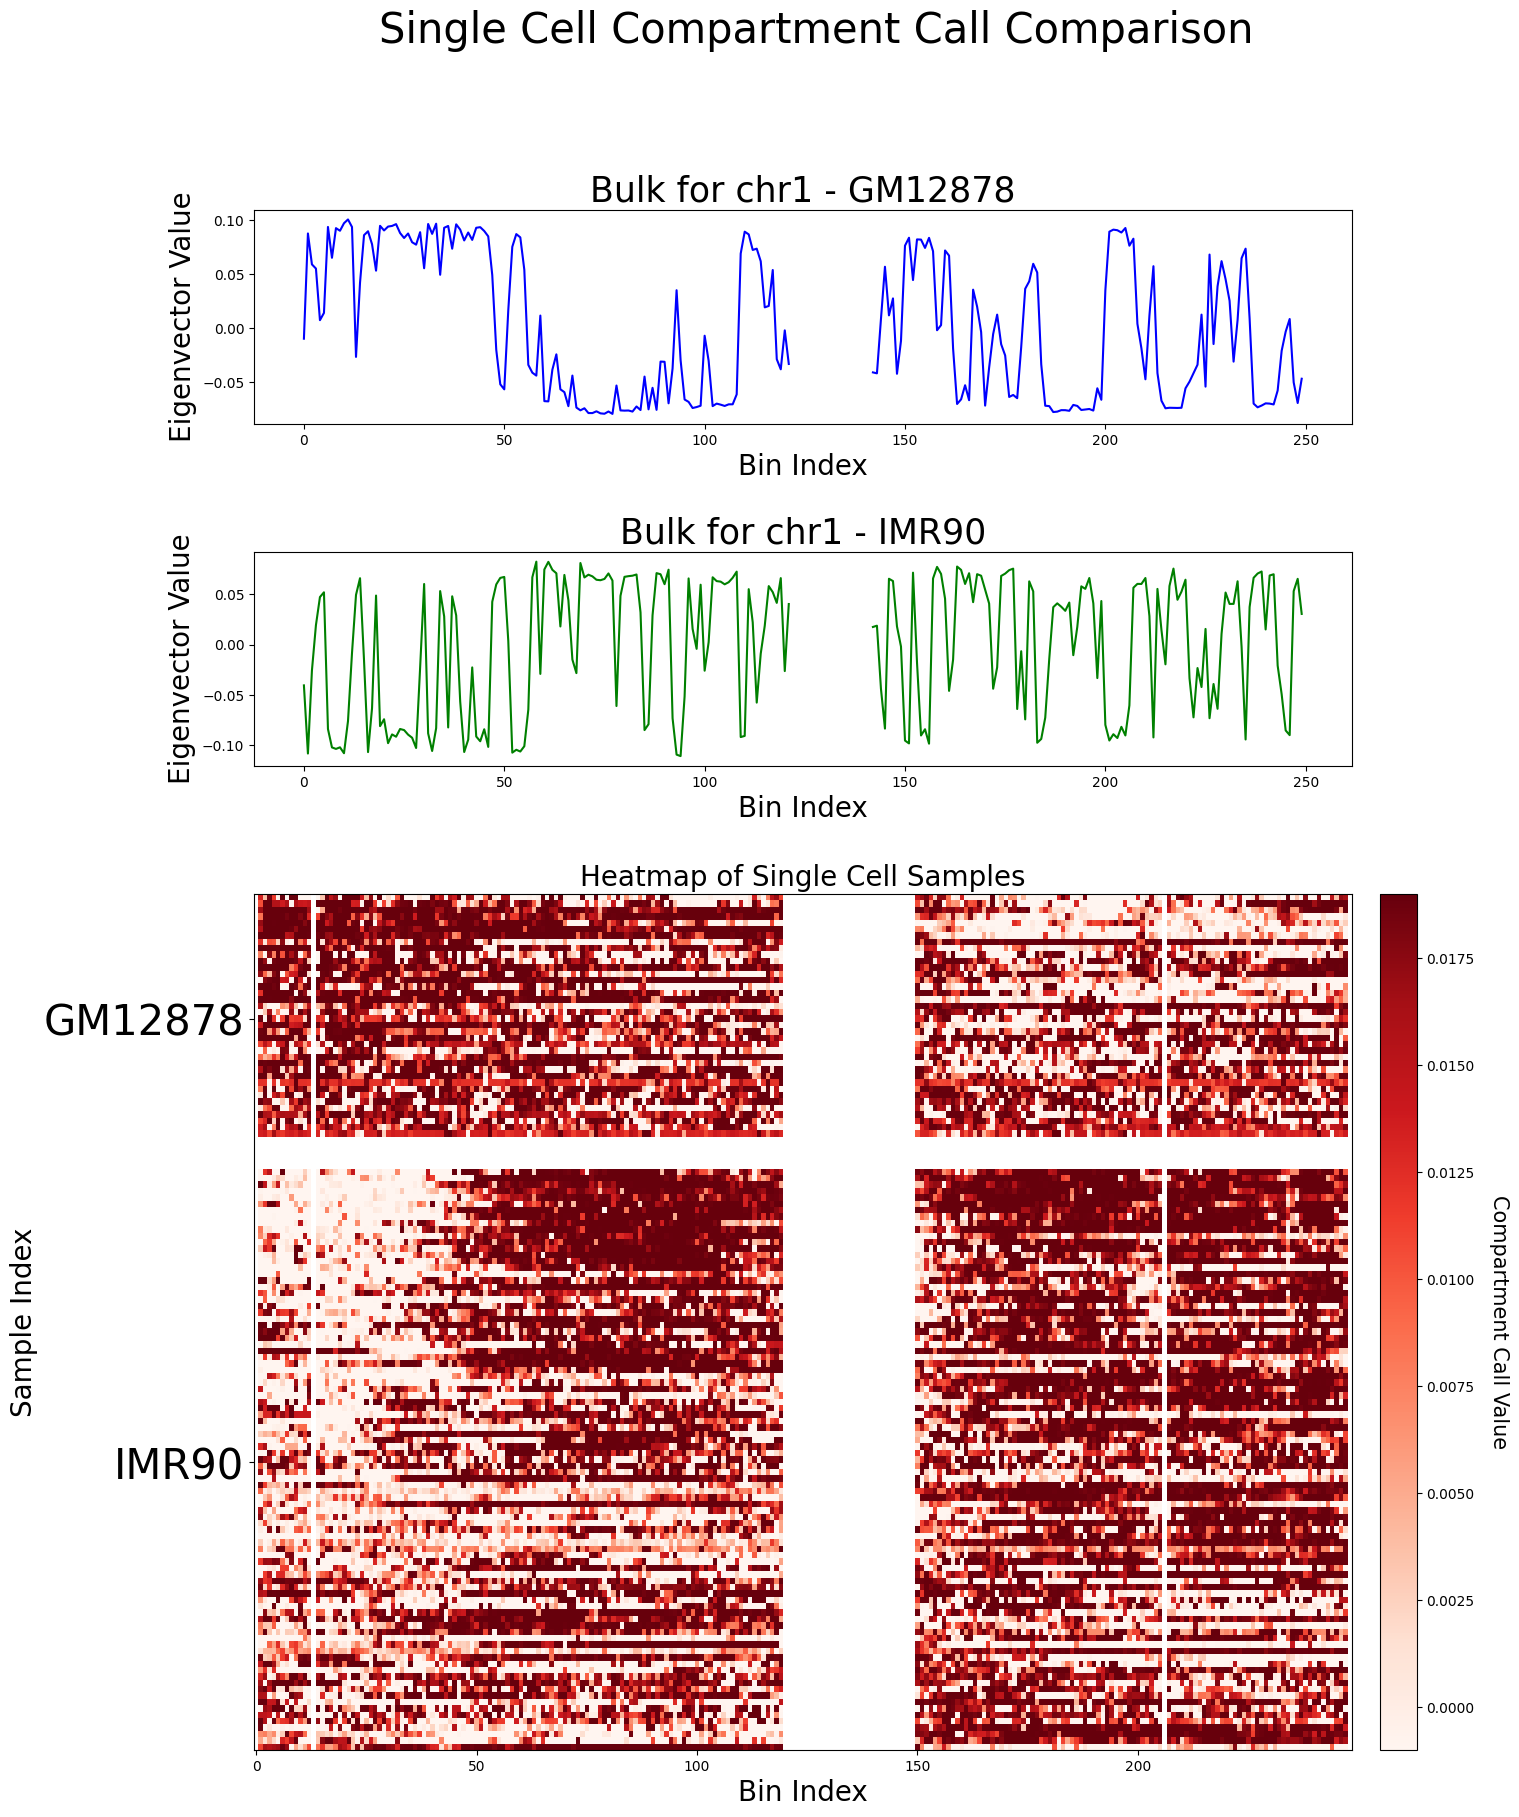

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 20))
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    # Plot Bulk Eigenvectors
    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='blue')
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=20)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=20)

    # Add separation rows
    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'gm12878']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'imr90']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    
    # Create empty rows filled with NaNs for separation
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    
    # Stack GM12878 data, empty rows, and IMR90 data
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    # Create the heatmap with a red colormap
    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap='Reds', interpolation='nearest')
    ax_sc.set_title("Heatmap of Single Cell Samples", fontsize=20)
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    # Add labels for GM12878 and IMR90 cell types
    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    # Colorbar for the heatmap
    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('Compartment Call Value', rotation=270, labelpad=25, fontsize=15)

    plt.suptitle(title, fontsize=30)

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    "Bulk for chr1 - GM12878",
    "Bulk for chr1 - IMR90",
    "Single Cell Compartment Call Comparison",
    save_path="../../files/AB_compartment_heatmap.png"  # Specify the file path to save the image
)
